In [340]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

## `Toy dataset check`

In [320]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.0
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

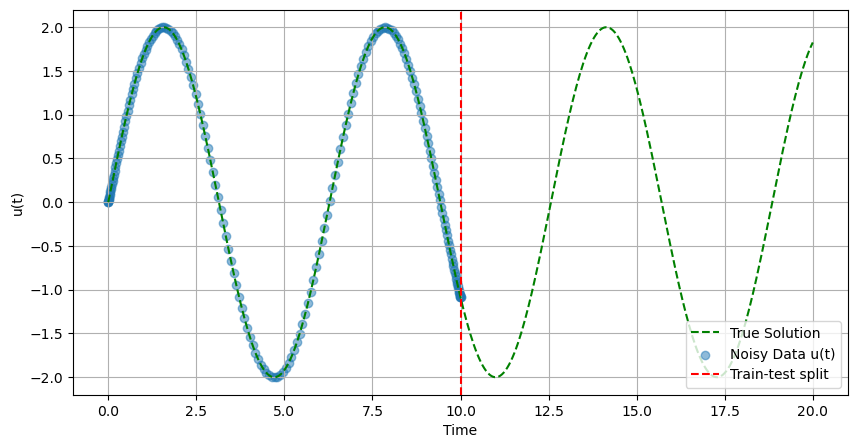

In [321]:
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [322]:
u = np.atleast_2d(y_noisy).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [325]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [326]:
n = 200
layer_widths = [1, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, "hessian_approximation": 'limited-memory', 
          'mu_strategy': 'adaptive', "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[:n], t[:n], D[:n, :n], layer_widths, max_iter = 1000, act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
y[0]**2 + (y[1] - 0.001246104742804665)**2 + (y[2] - 0.004984103579443402)**2 + (y[3] - 0.011213021411661368)**2 + (y[4] - 0.019931136768303326)**2 + (y[5] - 0.03113583785249508)**2 + (y[6] - 0.044823421492063024)**2 + (y[7] - 0.06098883530770227)**2 + (y[8] - 0.07962536574466655)**2 + (y[9] - 0.10072427208191422)**2 + (y[10] - 0.12427436814981194)**2 + (y[11] - 0.15026155346922646)**2 + (y[12] - 0.17866829572274615)**2 + (y[13] - 0.20947306667236776)**2 + (y[14] - 0.2426497453615358)**2 + (y[15] - 0.27816698033762016)**2 + (y[16] - 0.3159874413778424)**2 + (y[17] - 0.3560671659161782)**2 + (y[18] - 0.39835483495602164)**2 + (y[19] - 0.4427910223771647)**2 + (y[20] - 0.48930742685154877)**2 + (y[21] - 0.5378260908302837)**2 + (y[22] - 0.5882586111837013)**2 + (y[23] - 0.6405053461751475)**2 + (y[24] - 0.6944546459203257)**2 + (y[25] - 0.7499823369536248)**2 + (y[26] - 0.8069507480505177)**2 + (y[27] - 0.8652082718133398)**2 + (y[28] - 0.9245888716799514)**2 + (y[29] - 0.9849115584999

In [327]:
y_model = ode_model.extract_solution().T

In [328]:
ode_model.extract_weights();

Train MAE: 250.35130605049724
Test MAE: 751.3104699425393


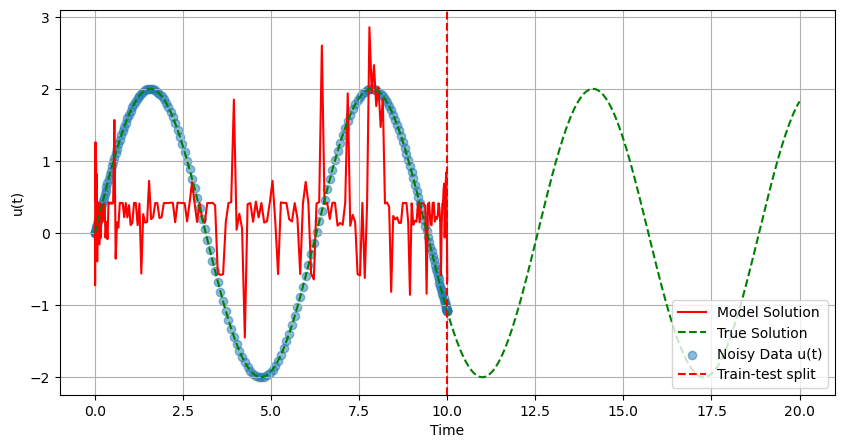

In [331]:
def system_dynamics(y, t):
    input = jnp.array([y[0]])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print(f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
#plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
#plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## Does it even Work?

In [341]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_ho_cheb = compute_weights(t_ho_cheb)
D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [342]:
layer_widths = [2, 10, 2]

params = {'tol': 1e-8, 'halt_on_ampl_error': 'yes'}
start_timer_build = time.time()
ode_model = NeuralODEPyomo(y_noisy_ho_cheb, t_ho_cheb, D_ho_cheb, layer_widths, max_iter = 1000, act_func = "tanh", w_init_method = 'xavier', params = params) # , y_init = estimated_solution_ho_cheb

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

y_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1]])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

(y1[0] - 0.0917288340454139)**2 + (y2[0] - 1.1241992255536868)**2 + (y1[1] + 0.03486286084436617)**2 + (y2[1] - 1.0493497194399821)**2 + (y1[2] + 0.046127501959942925)**2 + (y2[2] - 1.0277694966155562)**2 + (y1[3] - 0.23191471827779148)**2 + (y2[3] - 0.9914993756323086)**2 + (y1[4] + 0.03483373378005805)**2 + (y2[4] - 0.9826149035177948)**2 + (y1[5] - 0.004218517597705716)**2 + (y2[5] - 0.7223534072405706)**2 + (y1[6] - 0.12119887604176761)**2 + (y2[6] - 0.942293605104694)**2 + (y1[7] - 0.08878564019702319)**2 + (y2[7] - 1.096206984915602)**2 + (y1[8] + 0.013680857643002711)**2 + (y2[8] - 0.9329789295042056)**2 + (y1[9] + 0.12064460782928549)**2 + (y2[9] - 1.0111674502960541)**2 + (y1[10] + 0.1378164971384227)**2 + (y2[10] - 1.1461063013502333)**2 + (y1[11] - 0.23435132479023435)**2 + (y2[11] - 0.9120755039091278)**2 + (y1[12] - 0.1394107412707065)**2 + (y2[12] - 1.00682751750284)**2 + (y1[13] + 0.05013391765703537)**2 + (y2[13] - 0.8418174858443094)**2 + (y1[14] + 0.23306000446831382)

In [343]:
initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_ho_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_ho_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_ho_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_ho_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.8331952780570157
Test MAE: 0.7331509766546317


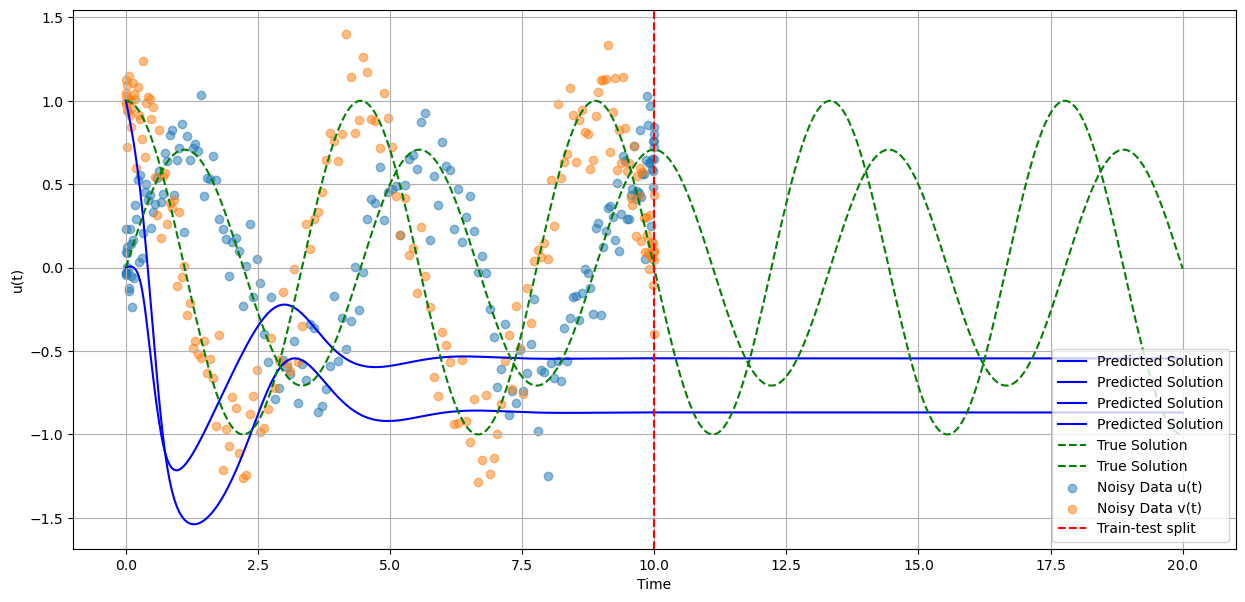

In [344]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_test_ho_cheb, 'g--', label='True Solution')
plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()